### The Cross Validation Method

투자가들은 종종 2008년의 금융 위기나 닷컴 버블, 긴축 발작, 2015~2016년 중국 주식 시장 요동 등과 같은 전례 없는 스트레스 시나리오에 처한다면 투자 전략의 성과가 어떻게 되는지를 묻고는 한다. 이에 대한 대답 중 하나는 관측값을 두 가지 집합으로 나눠 하나는 테스트하려는 기간으로 설정하고, 다른 하나는 훈련셋으로 설정하는 것이다. 분류기가 2009년 1월 1일에서 2017년 1월 1일까지 학습 했다면 테스트는 2008년 1월 1일에서 2008년 12월 31일에 대해 수행한다. 2008년에 얻어진 성과는 역사적으로 정확하지 않다. 이유는 분류기가 2008년 이후의 데이터에 대해서만 학습됐기 때문이다. 그러나 역사적 정확도는 이 테스트의 목적이 아니다. 목표는 2008년도 내용을 모르는 전략을 2008년과 같은 스트레스 시나리오에 테스트해 보는 것이다.

Cross Validation을 활용한 백테스트의 목표는 역사적으로 정확한 성과를 도출하려는 것이 아니라 다수의 샘플 외 시나리오로부터 미래의 성과를 추론하는 것이다. 백테스트의 각 기간 동안, 그 기간 이외의 모든 것을 알고 있는 분류기로 성과를 시뮬레이션한다.

In [11]:
import numpy as np
import pandas as pd
from FinancialMachineLearning.labeling.labeling import *

triple_barrier_event = pd.read_parquet('../../../Data/AAPL_triple_barrier_events.parquet')
avg_uniqueness = pd.read_parquet('../../../Data/AAPL_avg_unique.parquet')
feature_matrix = pd.read_parquet('../../../Data/AAPL_feature_matrix.parquet')

labels = meta_labeling(
    triple_barrier_event, 
    feature_matrix['Close']
)

triple_barrier_event['side'] = labels['bin']
meta_labels = meta_labeling(
    triple_barrier_event, # with side labels
    feature_matrix['Close']
)

#### Pros

1. 테스트는 특정 시나리오의 결과가 아니다. 사실 Cross Validation은 $k$개의 대체 시나리오를 테스트하는데 그중 하나만 역사적 시퀀스에 해당한다. 
2. 모든 결정은 동일한 크기의 집합에서 이뤄진다. 이러한 결정을 내릴 때 활용한 정보의 양 관점에서 여러 기간에 걸쳐 결과를 서로 비교할 수 있게 해준다.
3. 모든 관측은 하나의 그리고 오직 하나의 테스트셋에 속한다. 준비를 위한 부분 집합은 없으므로 가장 긴 샘플 외 시뮬레이션을 얻을 수 있다.

#### Cons

1. Walk Forward처런 단일 백테스트 경로가 시뮬레이션된다. 관측별로 오직 하나의 예측만 생성한다.
2. Cross Validation은 명확한 역사적 해석을 지니고 있지 않다. 출력은 전략이 과거에 어떻게 성과를 냈을까에 대한 시뮬레이션이 아니고, 다양한 스트레스 시나리오 하에서 미래에 어떻게 성과를 낼까에 대한 시뮬레이션이다.
3. 훈련셋이 테스트셋의 앞에 놓이는 것이 아니므로 정보 누출이 가능하다. 테스트셋 정보가 훈련셋으로 유출되는 것을 방지하기 위한 극도의 주의가 필요하다. Purging과 Embargo를 활용해 Cross Validation 맥락에서 정보 누출을 어떻게 방지하는지 Chapter 7을 참고하자.

In [12]:
feature_matrix['side'] = triple_barrier_event['side'].copy()
feature_matrix['label'] = meta_labels['bin'].copy()
feature_matrix.drop(['Open','High','Low','Close','Adj Close','Volume'], axis = 1, inplace = True)
feature_matrix.dropna(inplace = True)
matrix = feature_matrix[feature_matrix['side'] != 0]

X = matrix.drop(['side','label'], axis = 1)
y = matrix['label']

X_train, X_test = X.loc[:'2019'], X.loc['2020':]
y_train, y_test = y.loc[:'2019'], y.loc['2020':]

In [13]:
from sklearn.ensemble import RandomForestClassifier
from FinancialMachineLearning.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            triple_barrier_event.index.to_series(),
            triple_barrier_event['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [14]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [5]:
from FinancialMachineLearning.cross_validation.cross_validation import get_train_times, get_embargo_times

train_times, test_times = triple_barrier_event.loc[:'2019'], triple_barrier_event.loc['2019':]

In [6]:
train_times = get_train_times(train_times['t1'], test_times['t1'])

In [7]:
train_times.head()

Date
2000-01-07   2000-01-11
2000-01-10   2000-01-12
2000-01-11   2000-01-12
2000-01-12   2000-01-13
2000-01-13   2000-01-19
Name: t1, dtype: datetime64[ns]

In [8]:
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold

purged_k_fold = PurgedKFold(
    n_splits = 10,
    samples_info_sets = triple_barrier_event['t1'].loc[X_train.index],
    pct_embargo = 0.01
)

In [9]:
from FinancialMachineLearning.cross_validation.cross_validation import cross_val_score
from sklearn.metrics import log_loss

cross_validation_score = cross_val_score(
    classifier = forest,
    X = X_train,
    y = y_train,
    sample_weight = avg_uniqueness.loc[X_train.index].to_numpy().reshape(1, -1)[0],
    cv_gen = purged_k_fold,
    scoring = log_loss
)

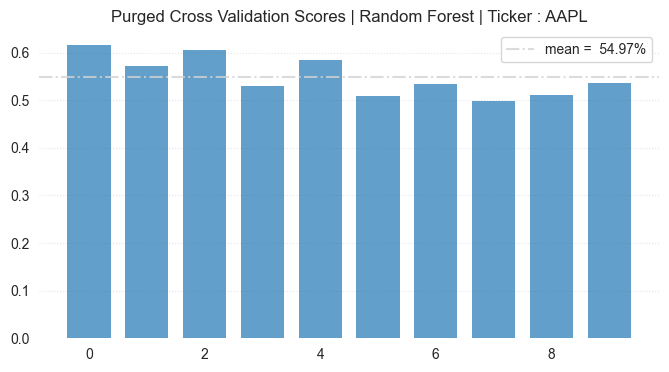

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    range(10),
    -cross_validation_score,
    width = 0.75,
    alpha = 0.7,
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5)
plt.axhline(
    y = np.mean(-cross_validation_score),
    ls = '-.',
    color = 'lightgray',
    alpha = 0.8,
    label = f'mean = {np.mean(-cross_validation_score) * 100 : .2f}%'
)
plt.legend()
plt.title('Purged Cross Validation Scores | Random Forest | Ticker : AAPL')
plt.show()